In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define the Teacher Model
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Student Model
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the Teacher Model
teacher_model = TeacherModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

def train_teacher():
    teacher_model.train()
    for epoch in range(10):
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = teacher_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train_teacher()




Epoch 1, Loss: 0.013509203679859638
Epoch 2, Loss: 0.02071220614016056
Epoch 3, Loss: 0.01137512270361185
Epoch 4, Loss: 0.001173771801404655
Epoch 5, Loss: 0.0004724313912447542
Epoch 6, Loss: 0.0009337138617411256
Epoch 7, Loss: 0.0016576950438320637
Epoch 8, Loss: 0.00019821988826151937
Epoch 9, Loss: 3.293948248028755e-05
Epoch 10, Loss: 1.054251697496511e-06


Generator Epoch 1, Loss: 0.12665313482284546


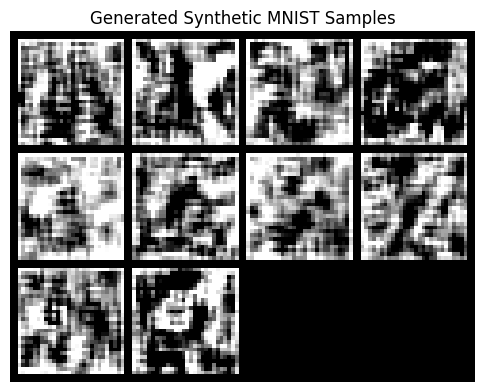

Generator Epoch 2, Loss: 0.14951413869857788


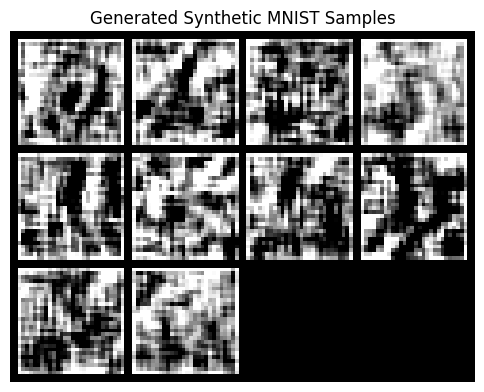

Generator Epoch 3, Loss: 0.03004727140069008


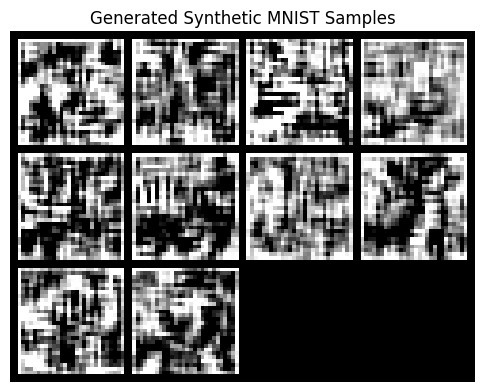

Generator Epoch 4, Loss: 0.0009557412704452872


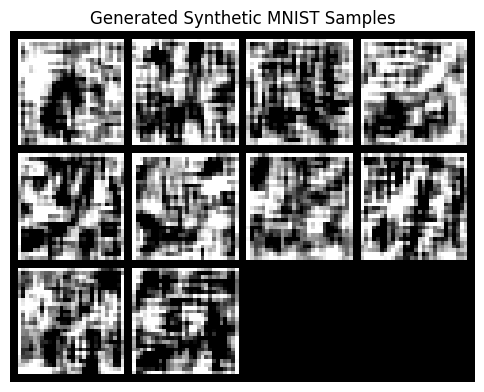

Generator Epoch 5, Loss: 0.04590043053030968


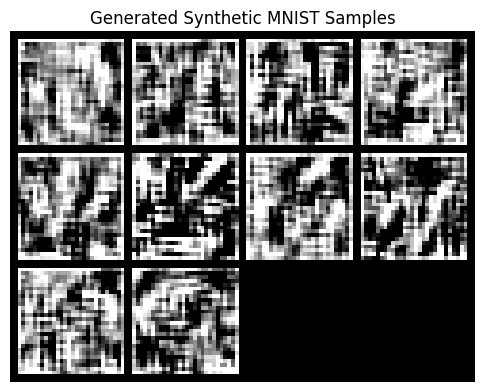

Generator Epoch 6, Loss: 0.05107491835951805


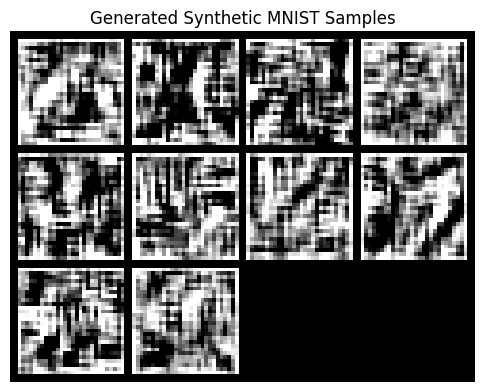

Generator Epoch 7, Loss: 0.0009073938708752394


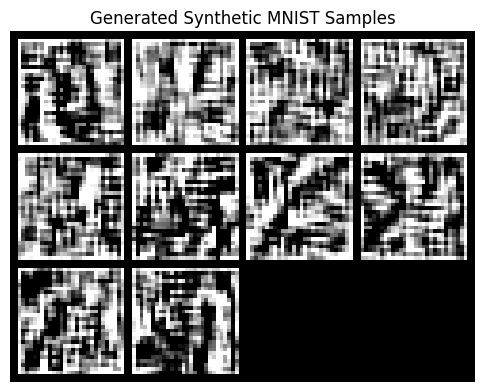

Generator Epoch 8, Loss: 0.0035222540609538555


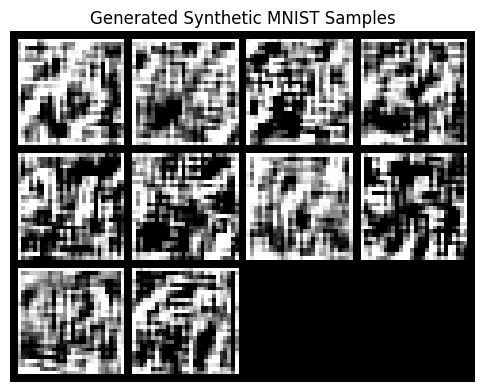

Generator Epoch 9, Loss: 0.006552377250045538


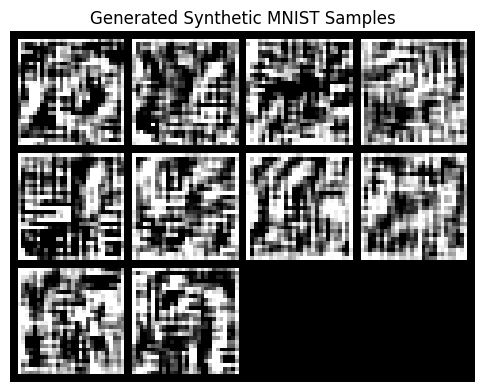

Generator Epoch 10, Loss: 8.797943883109838e-05


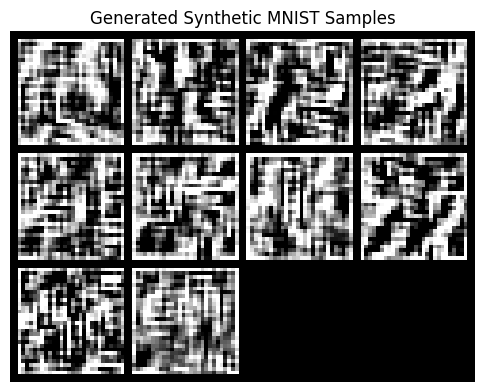

Generator Epoch 11, Loss: 0.02041945978999138


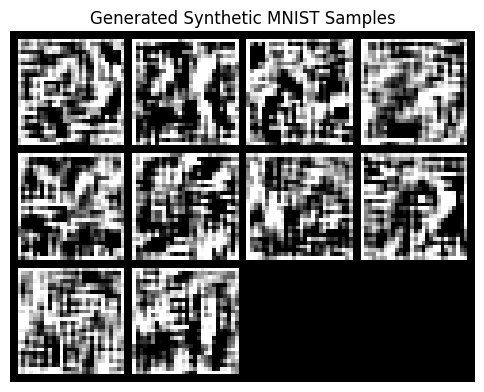

Generator Epoch 12, Loss: 0.003747900715097785


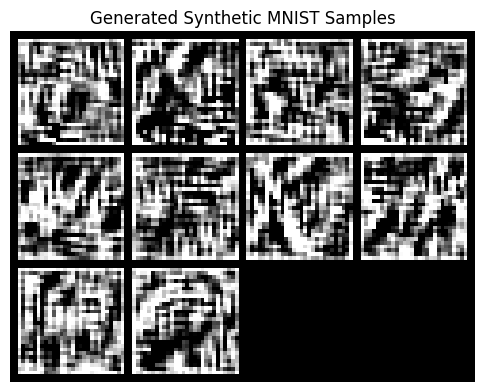

Generator Epoch 13, Loss: 0.0004917450714856386


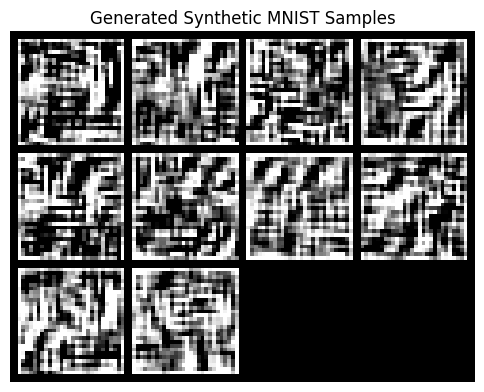

Generator Epoch 14, Loss: 2.0507279714365723e-06


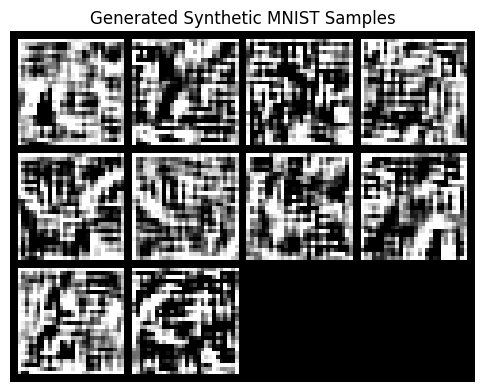

Generator Epoch 15, Loss: 0.01272951066493988


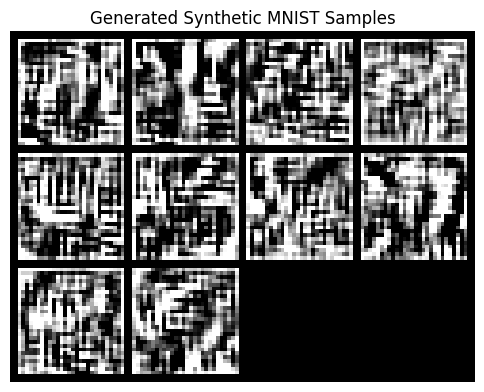

Generator Epoch 16, Loss: 0.003457368351519108


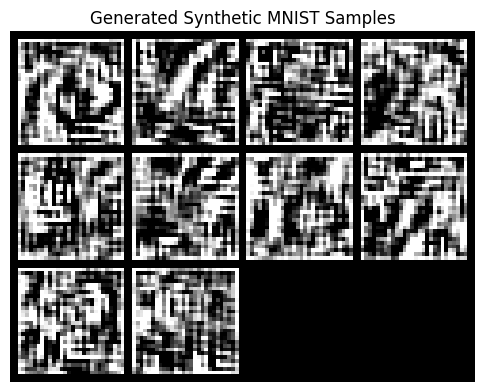

Generator Epoch 17, Loss: 3.3750343391147908e-06


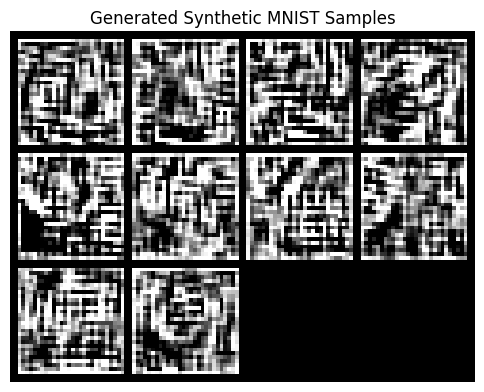

Generator Epoch 18, Loss: 3.604218363761902e-05


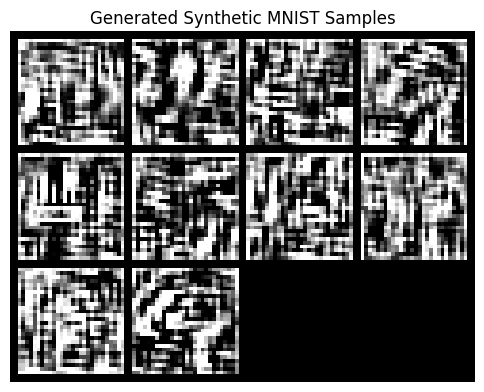

Generator Epoch 19, Loss: 1.6335026202796143e-06


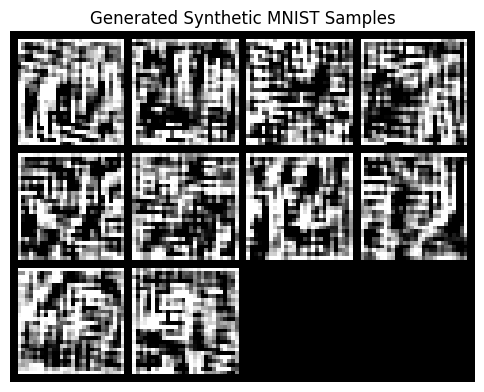

Generator Epoch 20, Loss: 0.000275838392553851


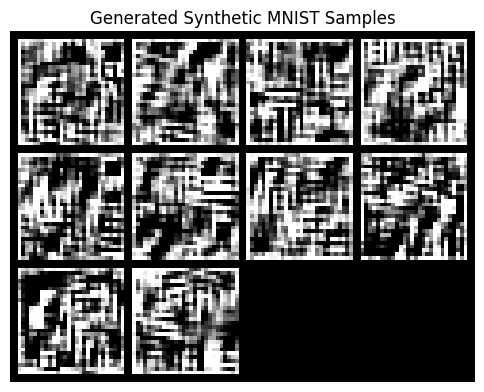

In [7]:
class GeneratorGDFQ(nn.Module):
    def __init__(self, options=None, conf_path=None):
        super(GeneratorGDFQ, self).__init__()
        self.label_emb = nn.Embedding(10, 100)
        self.init_size = 28 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks0 = nn.Sequential(
            nn.BatchNorm2d(128),
        )

        self.conv_blocks1 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv_blocks2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(1, affine=False)
        )

    def forward(self, z, labels):
        gen_input = torch.mul(self.label_emb(labels), z)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks0(out)
        img = nn.functional.interpolate(img, scale_factor=2)
        img = self.conv_blocks1(img)
        img = nn.functional.interpolate(img, scale_factor=2)
        img = self.conv_blocks2(img)
        return img





# Instantiate Conditional Generator
generator = GeneratorGDFQ().cuda()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
noise_dim = 100

def train_generator(teacher, epochs=20):
    teacher.eval()
    for epoch in range(epochs):
        for _ in range(len(train_loader)):
            z = torch.randn(64, noise_dim, device='cuda')
            targets = torch.randint(0, 10, (64,), device='cuda')
            gen_images = generator(z, targets)
            gen_optimizer.zero_grad()
            outputs = teacher(gen_images)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            gen_optimizer.step()
        print(f'Generator Epoch {epoch+1}, Loss: {loss.item()}')

        # Visualize generated images
        with torch.no_grad():
            z = torch.randn(10, noise_dim, device='cuda')
            labels = torch.arange(0, 10, device='cuda')
            samples = generator(z, labels).cpu().clamp(-1, 1) * 0.5 + 0.5
            grid = torchvision.utils.make_grid(samples, nrow=4)
            plt.figure(figsize=(6,6))
            plt.title("Generated Synthetic MNIST Samples")
            plt.axis('off')
            plt.imshow(grid.permute(1, 2, 0).numpy())
            plt.show()
train_generator(teacher_model)


In [8]:

# Generate synthetic data using trained generator
def generate_from_generator(generator, batch_size=64):
    z = torch.randn(batch_size, noise_dim, device='cuda')
    labels = torch.randint(0, 10, (batch_size,), device='cuda')
    with torch.no_grad():
        images = generator(z, labels)
    return images,labels

# Knowledge Distillation Loss Function
def kd_loss(student_logits, teacher_logits, labels, T=3, alpha=0.5):
    kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_logits/T, dim=1),
                                                  F.softmax(teacher_logits/T, dim=1)) * (T*T)
    ce_loss = criterion(student_logits, labels)
    return alpha * kd_loss + (1 - alpha) * ce_loss

# Train the Student Model using Knowledge Distillation
student_model = StudentModel().cuda()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

def train_student():
    teacher_model.eval()
    generator.eval()
    student_model.train()
    for epoch in range(5):
        for _ in range(len(train_loader)):
            z = torch.randn(64, noise_dim, device='cuda')
            labels = torch.randint(0, 10, (64,), device='cuda')
            images = generator(z, labels)
            optimizer.zero_grad()
            student_outputs = student_model(images)
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss = kd_loss(student_outputs, teacher_outputs,labels)
            loss.backward()
            optimizer.step()
        print(f'Student Epoch {epoch+1}, Loss: {loss.item()}')

train_student()

# Evaluate both models
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

teacher_acc = evaluate(teacher_model)
student_acc = evaluate(student_model)
print(f'Teacher Model Accuracy: {teacher_acc}%')
print(f'Student Model Accuracy: {student_acc}%')

Student Epoch 1, Loss: 0.05932245030999184
Student Epoch 2, Loss: 0.20482562482357025
Student Epoch 3, Loss: 0.027948977425694466
Student Epoch 4, Loss: 0.05494300276041031
Student Epoch 5, Loss: 0.031598836183547974
Teacher Model Accuracy: 99.05%
Student Model Accuracy: 87.97%
